In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Gemini in Education

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/use_cases_for_education.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


## Overview

In this notebook, you will explore a variety of use cases enabled by Gemini models in the context of education.

### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini Pro Vision and Gemini Pro models.

### Vertex AI Gemini API

The Vertex AI Gemini API provides a unified interface for interacting with Gemini models. There are currently two models available in the Gemini API:

- **Gemini Pro model** (`gemini-pro`): Designed to handle natural language tasks, multiturn text and code chat, and code generation.
- **Gemini Pro Vision model** (`gemini-pro-vision`): Supports multimodal prompts. You can include text, images, and video in your prompt requests and get text or code responses.

For more information, see the [Generative AI on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) documentation.


### Objectives

The main objective of this notebook is to demonstrate a variety of educational use cases that can benefit from the Gemini models.

The steps performed include:

- Installing the Python SDK
- Using the Vertex AI Gemini API
  - Using a text model (`gemini-pro`)
    - Reasoning at different levels
    - Reasoning on text
    - Reasoning on numbers
  - Using a multimodal model (`gemini-pro-vision`)
    - Reasoning on a single image
    - Reasoning on multiple images
    - Reasoning on a video


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information (Colab only)

If you are running this notebook on Google Colab, specify the Google Cloud project information to use. In the following cell, you specify your project information, import the Vertex AI package, and initialize the package. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [ ]:
if "google.colab" in sys.modules:
    # Define project information
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
    LOCATION = "us-central1"  # @param {type:"string"}

    # Initialize Vertex AI
    import vertexai

    vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [1]:
from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    Image,
    Part,
)

### Define helper functions

Define some helper functions to load and display images.


In [2]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

Contents = str | list[str | Image | Part]


def generate_content(
    model: GenerativeModel,
    contents: Contents,
    temperature: float = 0.0,
    top_p: float = 0.0,
    top_k: int = 1,
) -> list[GenerationResponse]:
    """Call the Vertex AI Gemini API.

    Default parameters have low randomness in this notebook for consistency across calls.
    """
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        candidate_count=1,
        max_output_tokens=2048,
    )

    responses = model.generate_content(
        contents,
        generation_config=generation_config,
        stream=True,
    )

    # In streaming mode, multiple GenerationResponse can be generated
    # In unary (non-streaming) mode, a single GenerationResponse is returned
    return [responses] if isinstance(responses, GenerationResponse) else list(responses)


def print_contents(contents: Contents):
    """Print the full contents for ease of readability."""
    if not isinstance(contents, list):
        contents = [contents]

    print(" Contents ".center(80, "-"))
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_image(content)
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_responses(responses: list[GenerationResponse], as_markdown: bool = True):
    """Print the full responses."""
    # Consolidate the text
    text = "".join(
        part.text
        for response in responses
        for part in response.candidates[0].content.parts
    )
    # Remove potential leading/trailing spaces
    text = text.strip()

    print(" Start of responses ".center(80, "-"))
    if as_markdown:
        IPython.display.display(IPython.display.Markdown(text))
    else:
        print(text)
    print(" End of responses ".center(80, "-"))
    print("")


def display_image(image: Image, max_width: int = 600, max_height: int = 350):
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")

    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))

    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image):
    """Display the image in a compressed format to reduce the notebook size."""
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes

## Use the Gemini Pro model

The Gemini Pro (`gemini-pro`) model is designed to handle natural language tasks, multiturn text and code chat, and code generation.


### Load the Gemini Pro model


In [3]:
model = GenerativeModel("gemini-pro")

### Reasoning at different levels


You can ask for direct answers:


In [4]:
contents = """
What happened to the dinosaurs? When?
Explain simply in one sentence.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

What happened to the dinosaurs? When?
Explain simply in one sentence.

------------------------------ Start of responses ------------------------------


A giant asteroid impact near what is now Mexico caused their extinction 66 million years ago.

------------------------------- End of responses -------------------------------



… as well as for more nuanced answers:


In [5]:
contents = """
Are we 100% sure about what happened to the dinosaurs?
If not, detail the current main hypotheses.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Are we 100% sure about what happened to the dinosaurs?
If not, detail the current main hypotheses.

------------------------------ Start of responses ------------------------------


No, we are not 100% sure about what happened to the dinosaurs. While the asteroid impact hypothesis is widely accepted, there are still some uncertainties and alternative hypotheses.

**1. Asteroid Impact Hypothesis:**

- This is the most widely accepted theory.
- It proposes that a massive asteroid or comet, approximately 6 miles in diameter, struck the Earth near what is now Chicxulub, Mexico, 66 million years ago.
- The impact caused a series of catastrophic events, including a massive earthquake, tsunami, and wildfires.
- The impact also released large amounts of dust and debris into the atmosphere, blocking sunlight and causing a global winter.
- This combination of events led to the extinction of the dinosaurs and many other species.

**2. Volcanic Eruptions Hypothesis:**

- This hypothesis suggests that massive volcanic eruptions in the Deccan Traps region of India, which lasted for several million years, released large amounts of greenhouse gases into the atmosphere.
- This caused global warming and climate change, leading to the extinction of the dinosaurs and other species.

**3. Disease Hypothesis:**

- This hypothesis proposes that a widespread disease or pathogen may have wiped out the dinosaurs.
- Evidence for this hypothesis includes the discovery of dinosaur bones with lesions and other signs of disease.

**4. Multiple Factors Hypothesis:**

- Some scientists believe that a combination of factors, including the asteroid impact, volcanic eruptions, and disease, may have contributed to the extinction of the dinosaurs.
- This hypothesis suggests that the asteroid impact and volcanic eruptions caused environmental changes that made the dinosaurs more susceptible to disease.

**5. Other Hypotheses:**

- There are several other hypotheses, such as changes in sea level, solar radiation, and comet showers, that have been proposed to explain the extinction of the dinosaurs.
- However, these hypotheses have less supporting evidence and are generally not as widely accepted as the asteroid impact hypothesis.

------------------------------- End of responses -------------------------------



You can ask for simple answers:


In [6]:
contents = """
Explain why it's winter here in France and summer in Australia.
I'm a kid. Answer in 3 simple key points.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Explain why it's winter here in France and summer in Australia.
I'm a kid. Answer in 3 simple key points.

------------------------------ Start of responses ------------------------------


1. The Earth is tilted on its axis.
2. As the Earth orbits the Sun, different parts of the planet receive more or less direct sunlight at different times of the year.
3. When it's winter in the Northern Hemisphere (where France is), it's summer in the Southern Hemisphere (where Australia is).

------------------------------- End of responses -------------------------------



… or for more detailed answers:


In [7]:
contents = """
Explain why we have tides.
I'm an adult. Provide a detailed answer using bullet points.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Explain why we have tides.
I'm an adult. Provide a detailed answer using bullet points.

------------------------------ Start of responses ------------------------------


- **Gravitational pull of the Moon:** The Moon's gravity exerts a pull on the Earth's oceans, causing them to bulge out slightly on the side facing the Moon. This creates a high tide.


- **Rotation of the Earth:** As the Earth rotates, different parts of the planet move through the Moon's gravitational field. This causes the tides to rise and fall twice a day.


- **Centrifugal force:** The Earth's rotation also creates a centrifugal force that acts outward from the center of the planet. This force counteracts the Moon's gravity, reducing the height of the tides.


- **Shape of the Earth:** The Earth's equatorial bulge and polar flattening also affect the tides. The bulge causes the tides to be higher at the equator than at the poles.


- **Sun's gravity:** The Sun's gravity also exerts a pull on the Earth's oceans, but its effect is smaller than that of the Moon. The Sun's gravity causes the tides to rise and fall slightly twice a month.


- **Resonance:** The Earth's rotation period and the Moon's orbital period are in resonance, meaning that they are synchronized. This resonance amplifies the tides, making them higher than they would be if the two periods were not in sync.

------------------------------- End of responses -------------------------------



You can ask closed questions:


In [8]:
contents = """
When were the previous and penultimate leap years?
List 3 international competitions that took place during the penultimate one.
Detail dates, cities, and venues.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

When were the previous and penultimate leap years?
List 3 international competitions that took place during the penultimate one.
Detail dates, cities, and venues.

------------------------------ Start of responses ------------------------------


- Previous leap year: 2020
- Penultimate leap year: 2016

### International competitions that took place in 2016:

1. **Summer Olympics**
   - Dates: August 5–21, 2016
   - City: Rio de Janeiro, Brazil
   - Venue: Various venues throughout the city, including the Maracanã Stadium, the Olympic Stadium, and the Barra Olympic Park.


2. **UEFA European Championship**
   - Dates: June 10–July 10, 2016
   - City: Various cities throughout France
   - Venue: Various stadiums throughout the country, including the Stade de France in Saint-Denis, the Parc des Princes in Paris, and the Stade Vélodrome in Marseille.


3. **Copa América Centenario**
   - Dates: June 3–26, 2016
   - City: Various cities throughout the United States
   - Venue: Various stadiums throughout the country, including the MetLife Stadium in East Rutherford, New Jersey, the Levi's Stadium in Santa Clara, California, and the CenturyLink Field in Seattle, Washington.

------------------------------- End of responses -------------------------------



… as well as questions that are more open:


In [9]:
contents = """
What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.

------------------------------ Start of responses ------------------------------


**Perspectives on the Chicken and Egg Question:**

1. **Biological Perspective:** From a biological standpoint, the egg came first. Chickens, like all other birds, reproduce by laying eggs. The egg contains all the necessary genetic material and nutrients for the development of a chick. The chicken, therefore, hatches from the egg, making the egg the starting point of the chicken's life cycle.

2. **Evolutionary Perspective:** From an evolutionary perspective, the chicken came first. Chickens evolved from a common ancestor shared with other birds. Over time, through natural selection, these ancestral birds developed the characteristics that we now associate with chickens, including the ability to lay eggs. The egg, in this sense, is a product of the evolutionary process that led to the development of chickens.

3. **Philosophical Perspective:** From a philosophical perspective, the question of which came first, the chicken or the egg, is a paradox. It challenges our understanding of causality and the concept of a beginning. Some philosophers argue that the question is unanswerable because it assumes a linear progression of events, which may not be applicable in this context. Others suggest that the chicken and the egg are interdependent and exist in a cyclical relationship, with each one giving rise to the other.

**Chicken and Egg Problem in Education:**

A "chicken and egg" problem in education refers to a situation where two factors are interdependent and mutually reinforcing, making it difficult to determine which one comes first or which one is the cause and which one is the effect.

One example of a chicken and egg problem in education is the relationship between student motivation and academic achievement. On the one hand, motivated students are more likely to achieve academically. On the other hand, students who achieve academically are more likely to be motivated to continue learning. In this scenario, it is difficult to determine whether motivation leads to achievement or achievement leads to motivation. Both factors influence each other, creating a cyclical relationship.

To address a chicken and egg problem in education, it is important to focus on interventions that target both factors simultaneously. For instance, to improve student motivation and academic achievement, educators can implement strategies that enhance student engagement, provide opportunities for success, and foster a positive learning environment. By addressing both motivation and achievement, educators can break the cycle and create a virtuous circle where each factor reinforces the other, leading to improved educational outcomes.

------------------------------- End of responses -------------------------------



### Reasoning on text


You can summarize and translate text:


In [10]:
contents = """
Summarize the following text in three sentences, in English, only using the text.

TEXT:
- Les hommes naissent et demeurent libres et égaux en droits. Les distinctions sociales ne peuvent être fondées que sur l'utilité commune.
- Le but de toute association politique est la conservation des droits naturels et imprescriptibles de l'homme. Ces droits sont la liberté, la propriété, la sûreté et la résistance à l'oppression.
- Le principe de toute souveraineté réside essentiellement dans la Nation. Nul corps, nul individu ne peut exercer d'autorité qui n'en émane expressément.
- La liberté consiste à pouvoir faire tout ce qui ne nuit pas à autrui : ainsi, l'exercice des droits naturels de chaque homme n'a de bornes que celles qui assurent aux autres membres de la société la jouissance de ces mêmes droits. Ces bornes ne peuvent être déterminées que par la loi.
La loi n'a le droit de défendre que les actions nuisibles à la société. Tout ce qui n'est pas défendu par la loi ne peut être empêché, et nul ne peut être contraint à faire ce qu'elle n'ordonne pas.
- La loi est l'expression de la volonté générale. Tous les citoyens ont droit de concourir personnellement ou par leurs représentants à sa formation. Elle doit être la même pour tous, soit qu'elle protège, soit qu'elle punisse. Tous les citoyens, étant égaux à ses yeux, sont également admissibles à toutes dignités, places et emplois publics, selon leur capacité et sans autre distinction que celle de leurs vertus et de leurs talents.
- Nul homme ne peut être accusé, arrêté ou détenu que dans les cas déterminés par la loi et selon les formes qu'elle a prescrites. Ceux qui sollicitent, expédient, exécutent ou font exécuter des ordres arbitraires doivent être punis ; mais tout citoyen appelé ou saisi en vertu de la loi doit obéir à l'instant ; il se rend coupable par la résistance.
- La loi ne doit établir que des peines strictement et évidemment nécessaires, et nul ne peut être puni qu'en vertu d'une loi établie et promulguée antérieurement au délit, et légalement appliquée.
Tout homme étant présumé innocent jusqu'à ce qu'il ait été déclaré coupable, s'il est jugé indispensable de l'arrêter, toute rigueur qui ne serait pas nécessaire pour s'assurer de sa personne doit être sévèrement réprimée par la loi.
- Nul ne doit être inquiété pour ses opinions, même religieuses, pourvu que leur manifestation ne trouble pas l'ordre public établi par la loi.

SUMMARY:
-
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Summarize the following text in three sentences, in English, only using the text.

TEXT:
- Les hommes naissent et demeurent libres et égaux en droits. Les distinctions sociales ne peuvent être fondées que sur l'utilité commune.
- Le but de toute association politique est la conservation des droits naturels et imprescriptibles de l'homme. Ces droits sont la liberté, la propriété, la sûreté et la résistance à l'oppression.
- Le principe de toute souveraineté réside essentiellement dans la Nation. Nul corps, nul individu ne peut exercer d'autorité qui n'en émane expressément.
- La liberté consiste à pouvoir faire tout ce qui ne nuit pas à autrui : ainsi, l'exercice des droits naturels de chaque homme n'a de bornes que celles qui assurent aux autres membres de la société la jouissance de ces mêmes droits. Ces bornes ne peuvent être déterminées que par la loi.
La loi n'a le droit de défendre que les actions nu

- The Declaration of the Rights of Man and of the Citizen establishes that all men are born free and equal in rights, and that the purpose of political association is to preserve natural and imprescriptible rights, such as liberty, property, security, and resistance to oppression.
- The principle of sovereignty resides in the nation, and no body or individual can exercise authority that does not expressly emanate from it.
- The law is the expression of the general will, and all citizens have the right to contribute personally or through their representatives to its formation.

------------------------------- End of responses -------------------------------



… as well as ask for ideas:


In [11]:
contents = """
Provide an outline in 5 key points for a "chocolate in the world" presentation.
One part must be about its origin in Mexico (my teacher has family there).
The last one will be a tasting with everybody in the classroom.
"""

# For more creative/diverse answers, let's increase the level of randomness.
# Successive requests will likely return different responses.
temperature = 0.7
top_p = 0.8
top_k = 40

responses = generate_content(model, contents, temperature, top_p, top_k)

print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Provide an outline in 5 key points for a "chocolate in the world" presentation.
One part must be about its origin in Mexico (my teacher has family there).
The last one will be a tasting with everybody in the classroom.

------------------------------ Start of responses ------------------------------


1. **Chocolate Origins**:
   - Discuss the history of chocolate, tracing its roots back to ancient Mesoamerica.
   - Highlight the significance of Mexico as the birthplace of chocolate, with a focus on your teacher's family connection to the region.
   - Describe the traditional methods of chocolate cultivation and preparation used by indigenous communities in Mexico.

2. **Global Spread of Chocolate**:
   - Explain how chocolate was introduced to Europe by Spanish explorers and quickly gained popularity as a luxury item.
   - Mention the role of trade and colonization in spreading chocolate to different parts of the world, including Africa, Asia, and the Americas.
   - Discuss the evolution of chocolate production techniques, from small-scale artisanal methods to large-scale industrial manufacturing.

3. **Health Benefits**:
   - Present scientific evidence supporting the health benefits of chocolate, such as its antioxidant properties, potential heart health benefits, and mood-boosting effects.
   - Emphasize the importance of consuming chocolate in moderation and choosing high-quality, dark chocolate with a high cocoa content.
   - Address common misconceptions about chocolate being unhealthy and debunk any myths surrounding its consumption.

4. **Cultural Significance**:
   - Explore the cultural significance of chocolate in different societies around the world, including its use in religious ceremonies, festivals, and celebrations.
   - Discuss the role of chocolate in art, literature, and popular culture, highlighting famous chocolate-inspired works and traditions.
   - Mention the social and economic impact of the chocolate industry, including its role in supporting cocoa-growing communities and promoting sustainable farming practices.

5. **Tasting**:
   - Conduct a chocolate tasting session with the class, providing a variety of chocolate samples with different cocoa percentages, flavors, and origins.
   - Guide the students through a sensory evaluation process, encouraging them to identify and describe the different characteristics of each chocolate.
   - Discuss the factors that influence the taste and quality of chocolate, such as the cocoa bean variety, fermentation, roasting, and conching processes.

------------------------------- End of responses -------------------------------



You can also ask for text corrections:

Below, you can provide some examples of expected responses (i.e. few-shot prompting) so that the model can understand what kind of response you are expecting.


In [12]:
contents = """
I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You recieved important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You recieved important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!

------------------------------ Start of responses ------------------------------


- **They're twins, isn't it?**
  - Status: ❌
  - Correction: **They're twins, aren't they?**
  - Explanation:
    - "**isn't it**" is incorrect. It should be "**aren't they**" because "**they**" is plural.


- **I assisted to the meeting.**
  - Status: ❌
  - Correction: **I attended the meeting.**
  - Explanation:
    - "**assisted**" is incorrect. It seems that you meant "**attended**", which means to be present at an event.


- **You recieved important informations.**
  - Status: ❌
  - Correction: **You received important information.**
  - Explanation:
    - "**recieved**" is misspelled. The correct spelling is "**received**".
    - "**informations**" is incorrect. It should be "**information**" because "**information**" is uncountable.


- **I digged a hole in the ice and saw lots of fishes.**
  - Status: ❌
  - Correction: **I dug a hole in the ice and saw many fish.**
  - Explanation:
    - "**digged**" is incorrect. The past tense of "**dig**" is "**dug**".
    - "**fishes**" is incorrect. It should be "**fish**" because "**fish**" is uncountable.


- **That's all folks!**
  - Status: ✔️

------------------------------- End of responses -------------------------------



… as well as ask for elaborate tasks on text and languages:


In [13]:
contents = """
Translate the text into the following languages.

TEXT:
Hello folks! I hope you're all doing well. Let's get this workshop started!
We'll stick to English because, actually, I can't speak all those languages.

LANGUAGES:
German, French, Greek, Bulgarian, Japanese
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Translate the text into the following languages.

TEXT:
Hello folks! I hope you're all doing well. Let's get this workshop started!
We'll stick to English because, actually, I can't speak all those languages.

LANGUAGES:
German, French, Greek, Bulgarian, Japanese

------------------------------ Start of responses ------------------------------


**German:**
Hallo Leute! Ich hoffe, es geht euch allen gut. Lasst uns diesen Workshop beginnen!
Wir bleiben beim Englischen, weil ich tatsächlich nicht all diese Sprachen sprechen kann.

**French:**
Bonjour à tous ! J'espère que vous allez tous bien. Commençons cet atelier !
Nous nous en tiendrons à l'anglais car, en fait, je ne parle pas toutes ces langues.

**Greek:**
Γεια σας παιδιά! Ελπίζω να είστε όλοι καλά. Ας ξεκινήσουμε αυτό το εργαστήριο!
Θα μείνουμε στα Αγγλικά γιατί, στην πραγματικότητα, δεν μπορώ να μιλήσω όλες αυτές τις γλώσσες.

**Bulgarian:**
Здравейте, хора! Надявам се, че всички сте добре. Нека започнем този семинар!
Ще се придържаме към английския, защото всъщност не мога да говоря всички тези езици.

**Japanese:**
皆さん、こんにちは！皆さんお元気ですか？それでは、ワークショップを始めましょう！
英語で進めさせていただきます。というのも、私はそれ以外の言語を話せないからです。

------------------------------- End of responses -------------------------------



In [14]:
contents = """
I'm a non-native English speaker and made mistakes in the following sentences.
Guess my native language.
Explain why these are typical mistakes.
If there are several possibilities, here is a hint: I like cheese.

SENTENCES:
- They are twin sisters, isn't it?
- I assisted to the meeting.
- I saw lots of fishes.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

I'm a non-native English speaker and made mistakes in the following sentences.
Guess my native language.
Explain why these are typical mistakes.
If there are several possibilities, here is a hint: I like cheese.

SENTENCES:
- They are twin sisters, isn't it?
- I assisted to the meeting.
- I saw lots of fishes.

------------------------------ Start of responses ------------------------------


Your native language is likely French.

Here are the explanations for each mistake:

- "They are twin sisters, isn't it?"
   - In English, the correct way to say this would be "They are twin sisters, aren't they?"
   - In French, the verb "être" (to be) is conjugated differently for different subjects, including the third person plural "ils/elles" (they).
   - The correct conjugation for "ils/elles" is "sont", which is why you might have made this mistake.


- "I assisted to the meeting."
   - In English, the correct way to say this would be "I attended the meeting."
   - In French, the verb "assister" (to attend) is often used with the preposition "à" (to).
   - This is why you might have made the mistake of using "assisted to" instead of "attended".


- "I saw lots of fishes."
   - In English, the correct way to say this would be "I saw lots of fish."
   - In French, the word "poisson" (fish) is used in the plural form "poissons" when referring to multiple fish.
   - This is why you might have made the mistake of using "fishes" instead of "fish".

------------------------------- End of responses -------------------------------



### Reasoning on numbers


> Note: Like any LLM, Gemini generates plausible-sounding outputs, but may still hallucinate. Depending on inputs and parameters, outputs can be inaccurate, including math operations. As a best practice, you may want to consider prompting the LLM with step-by-step instructions to reduce hallucinations, or use a calculator library rather than an LLM.

You can ask about real life problems:


In [15]:
contents = """
Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.

------------------------------ Start of responses ------------------------------


1. **Monday:**
   - Distance = Speed × Time
   - Distance = 12 km/h × 1.5 h
   - Distance = 18 km

2. **Tuesday:**
   - Time = Distance / Speed
   - Time = 21 km / 12 km/h
   - Time = 1.75 hours or 1 hour and 45 minutes

3. **Wednesday:**
   - Distance = Speed × Time
   - Distance = 12 km/h × 2.5 h
   - Distance = 30 km

4. **Marathon (42 km):**
   - Time = Distance / Speed
   - Time = 42 km / 12 km/h
   - Time = 3.5 hours or 3 hours and 30 minutes

5. **To complete a marathon in 3 hours:**
   - Speed = Distance / Time
   - Speed = 42 km / 3 h
   - Speed = 14 km/h
   - Increase in speed = 14 km/h - 12 km/h = 2 km/h

------------------------------- End of responses -------------------------------



… or about classical problems:


In [16]:
contents = """
I just borrowed 1,000 EUR from a friend.
We agreed on a 4.5% simple interest rate.
I want to know how much I'll have to refund in 1, 2, or 3 years.
Present the results in a recap table.
"""
responses = generate_content(model, contents)
print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

I just borrowed 1,000 EUR from a friend.
We agreed on a 4.5% simple interest rate.
I want to know how much I'll have to refund in 1, 2, or 3 years.
Present the results in a recap table.

------------------------------ Start of responses ------------------------------


| Year | Interest | Principal | Total |
|---|---|---|---|
| 1 | 45 EUR | 1,000 EUR | 1,045 EUR |
| 2 | 90 EUR | 1,000 EUR | 1,090 EUR |
| 3 | 135 EUR | 1,000 EUR | 1,135 EUR |

------------------------------- End of responses -------------------------------



## Using the Gemini Pro Vision model

Gemini Pro Vision (`gemini-pro-vision`) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.


In [17]:
multimodal_model = GenerativeModel("gemini-pro-vision")

### Reasoning on a single image


You can ask for an image description:


----------------------------------- Contents -----------------------------------
Describe this image:


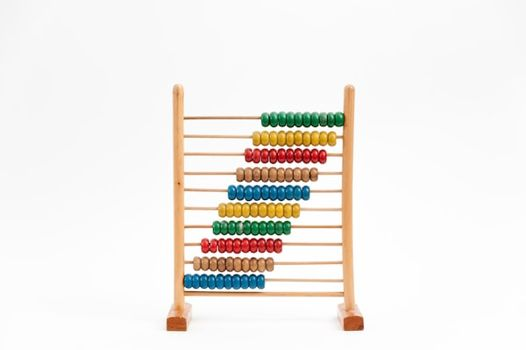

------------------------------ Start of responses ------------------------------


The image shows a wooden abacus with ten rows of beads. The beads are arranged in groups of ten, with each group having one bead of a different color. The abacus is standing on a white surface.

------------------------------- End of responses -------------------------------



In [18]:
prompt = "Describe this image:"
# Image by Crissy Jarvis on Unsplash: https://unsplash.com/photos/cHhbULJbPwM
image_abacus = load_image_from_url(
    "https://unsplash.com/photos/cHhbULJbPwM/download?w=600"
)

contents = [prompt, image_abacus]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

… or ask specific questions:


----------------------------------- Contents -----------------------------------

Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?



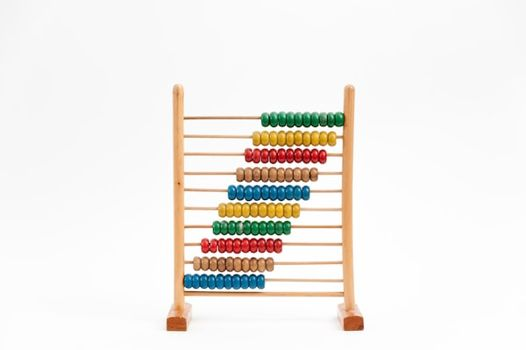

------------------------------ Start of responses ------------------------------


```json
[
  {
    "question": "What does the image show?",
    "answer": "The image shows an abacus."
  },
  {
    "question": "How does it work?",
    "answer": "An abacus is a calculating tool that has been used for centuries. It is made up of a frame with rows of beads. Each row represents a different place value, and the beads are used to represent numbers."
  },
  {
    "question": "When was it invented?",
    "answer": "The abacus was invented in ancient China around 2000 BC."
  },
  {
    "question": "What's the name of this object in French, Italian, Spanish, Dutch, and German?",
    "answer": "The French word for abacus is boulier, the Italian word is pallottoliere, the Spanish word is \u00e1baco, the Dutch word is rekenrek, and the German word is Rechenbrett."
  },
  {
    "question": "What are the most prominent colors in the image?",
    "answer": "The most prominent colors in the image are red, yellow, green, and blue."
  }
]
```

------------------------------- End of responses -------------------------------



In [19]:
prompt = """
Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?
"""

contents = [prompt, image_abacus]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

Your specific questions can have follow-up questions:


----------------------------------- Contents -----------------------------------


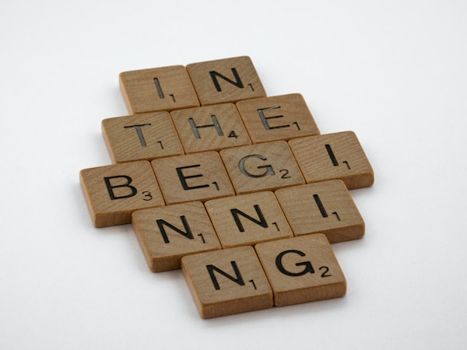


- What expression can be read in this image? How is it presented?
- What is the opposite expression?
- What is a recommendation, starting with this expression, a teacher could give his students for an exam?
- With the opposite expression?

------------------------------ Start of responses ------------------------------


- The expression that can be read in this image is "In the beginning". It is presented using wooden tiles with letters on them.
- The opposite expression is "In the end".
- A recommendation a teacher could give his students for an exam, starting with the expression "In the beginning", could be: "In the beginning, take a deep breath and relax. Read the instructions carefully and answer the questions to the best of your ability."
- With the opposite expression, the teacher could say: "In the end, check your work carefully and make sure you have answered all of the questions."

------------------------------- End of responses -------------------------------



In [20]:
# Image by Brett Jordan on Unsplash: https://unsplash.com/photos/E1por_SGvJE
image_tiles = load_image_from_url(
    "https://unsplash.com/photos/E1por_SGvJE/download?w=600"
)
prompt = """
- What expression can be read in this image? How is it presented?
- What is the opposite expression?
- What is a recommendation, starting with this expression, a teacher could give his students for an exam?
- With the opposite expression?
"""

contents = [image_tiles, prompt]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

Information can have multiple forms. It can be objects, printed text, handwritten text, and more:


----------------------------------- Contents -----------------------------------

Follow the instructions.
Write math expressions in LaTex.
Use a table with a row for each instruction and its result.

INSTRUCTIONS:
- Extract the formula.
- What is the symbol right before Pi? What does it mean?
- Is this a famous formula? Does it have a name?
- Why is it special?
- Extract the caption.
- What's the object in the bottom?
- What was it used for?
- What colors are the caption and the formula?



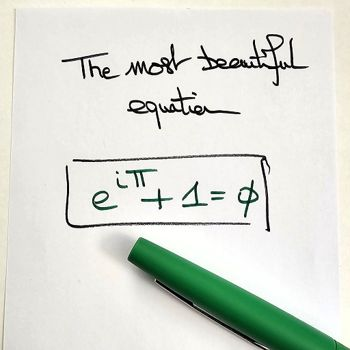

------------------------------ Start of responses ------------------------------


| Instruction | Result |
| -------- | -------- |
| Extract the formula. | $$e^{i\pi}+1=0$$ |
| What is the symbol right before Pi? What does it mean? | The symbol is i. It is the imaginary unit, which is a mathematical concept that is used to represent the square root of -1. |
| Is this a famous formula? Does it have a name? | Yes, it is known as Euler's identity. |
| Why is it special? | It is considered to be one of the most beautiful equations in mathematics because of its simplicity and elegance, and because it relates five fundamental mathematical constants: e, i, π, 1, and 0. |
| Extract the caption. | "The most beautiful equation" |
| What's the object in the bottom? | It's a green pen. |
| What was it used for? | It was used to write the formula. |
| What colors are the caption and the formula? | The caption is black and the formula is green. |

------------------------------- End of responses -------------------------------



In [21]:
prompt = """
Follow the instructions.
Write math expressions in LaTex.
Use a table with a row for each instruction and its result.

INSTRUCTIONS:
- Extract the formula.
- What is the symbol right before Pi? What does it mean?
- Is this a famous formula? Does it have a name?
- Why is it special?
- Extract the caption.
- What's the object in the bottom?
- What was it used for?
- What colors are the caption and the formula?
"""
image_euler = load_image_from_url(
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/math_beauty.jpg"
)

contents = [prompt, image_euler]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

You can also ask for interpretations and suggestions:


----------------------------------- Contents -----------------------------------

Answer the following questions about the image.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is visible?
- What are the reasons it's funny?
- What could be a fun caption?
- What could happen next?
- How would you alter the image? Would it still be funny and why?
- How would you make it funnier?



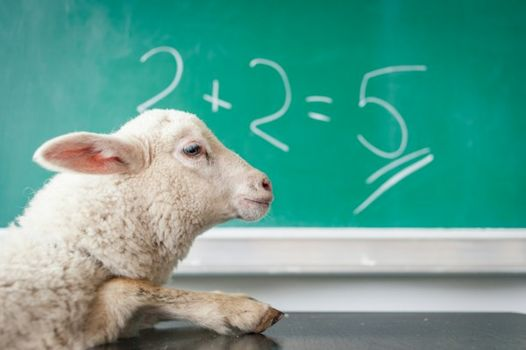

------------------------------ Start of responses ------------------------------


| Question                                             | Answer                                                                                                      |
|-----------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| What is visible?                                    | A lamb is lying in front of a chalkboard. The lamb is looking at the chalkboard.                          |
| What are the reasons it's funny?                    | The lamb is in a classroom. It is looking at a math problem on the chalkboard. The math problem is 2 + 2 = 5. The lamb is thinking about the math problem. It is trying to figure out the answer. The lamb is confused. It does not know the answer. |
| What could be a fun caption?                         | "I'm not very good at math."                                                                             |
| What could happen next?                             | The lamb will give up on the math problem. It will go back to sleep.                                         |
| How would you alter the image? Would it still be funny and why? | I would add a speech bubble to the lamb. In the speech bubble, I would write, "I'm not very good at math." I think this would make the image funnier because it would make it clear that the lamb is confused about the math problem. |
| How would you make it funnier?                       | I would add a second lamb to the image. The second lamb would be sitting next to the first lamb. The second lamb would be looking at the math problem. The second lamb would be very confused. It would not know the answer to the math problem. I think this would make the image funnier because it would show that the lamb is not alone in its confusion. |

------------------------------- End of responses -------------------------------



In [22]:
prompt = """
Answer the following questions about the image.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is visible?
- What are the reasons it's funny?
- What could be a fun caption?
- What could happen next?
- How would you alter the image? Would it still be funny and why?
- How would you make it funnier?
"""
# Image by Elimende Inagella on Unsplash: https://unsplash.com/photos/4ApmfdVo32Q
image_classroom = load_image_from_url(
    "https://unsplash.com/photos/4ApmfdVo32Q/download?w=600"
)

contents = [prompt, image_classroom]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

### Reasoning on multiple images


You can also use multiple images:


----------------------------------- Contents -----------------------------------

Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place?

Image 1:


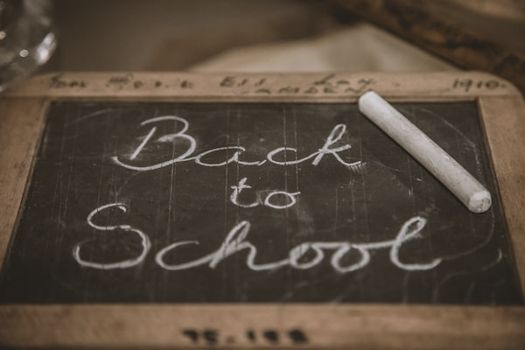

Image 2:


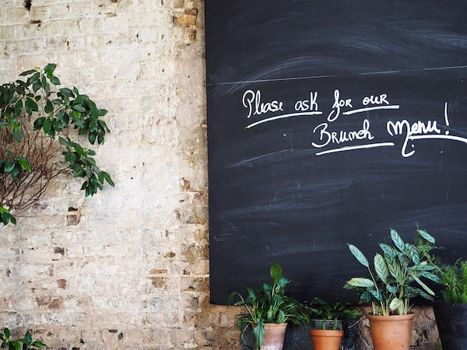

Image 3:


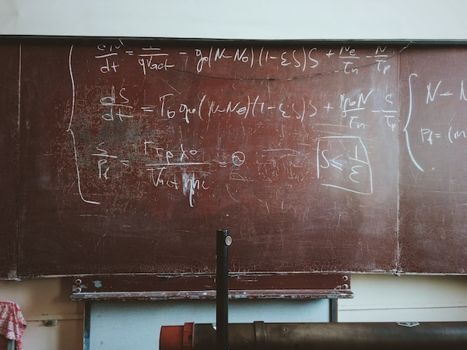

------------------------------ Start of responses ------------------------------


| Image | What can we see in the image? | Where does it take place? |
|---|---|---|
| Image 1 | A blackboard with the words "Back to School" written on it | A classroom |
| Image 2 | A blackboard with the words "Please ask for our brunch menu" written on it | A restaurant |
| Image 3 | A blackboard with a lot of math equations written on it | A classroom |

------------------------------- End of responses -------------------------------



In [23]:
prompt = f"""
Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place?
"""
caption_b1 = "Image 1:"
caption_b2 = "Image 2:"
caption_b3 = "Image 3:"
# Photo by Deleece Cook on Unsplash: https://unsplash.com/photos/zzjLGF_6dx4
image_b1 = load_image_from_url("https://unsplash.com/photos/zzjLGF_6dx4/download?w=600")
# Photo by Natasha Kapur on Unsplash: https://unsplash.com/photos/ndAHi2Wxcok
image_b2 = load_image_from_url("https://unsplash.com/photos/ndAHi2Wxcok/download?w=600")
# Photo by Roman Mager on Unsplash: https://unsplash.com/photos/5mZ_M06Fc9g
image_b3 = load_image_from_url("https://unsplash.com/photos/5mZ_M06Fc9g/download?w=600")

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

… or make comparisons between images:


----------------------------------- Contents -----------------------------------

Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What do the images have in common?
- Which one would be of interest to a mathematician?
- Which one indicates it's the end of vacation?
- Which one suggests we may get a coffee there?

Image 1:


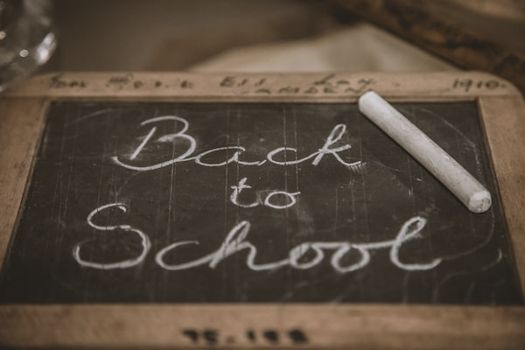

Image 2:


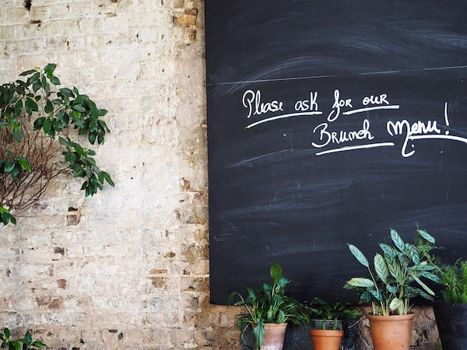

Image 3:


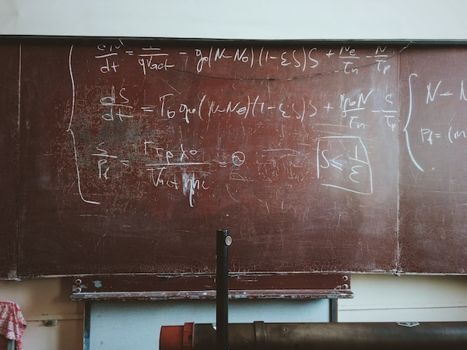

------------------------------ Start of responses ------------------------------


| Question                                             | Answer                                             | Reason                                                                                                                               |
|-----------------------------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| What do the images have in common?                     | They are all images of chalkboards.                | The images all have a chalkboard as the subject.                                                                                  |
| Which one would be of interest to a mathematician?   | Image 3                                              | Image 3 is a chalkboard full of math equations.                                                                                   |
| Which one indicates it's the end of vacation?        | Image 1                                              | Image 1 says, "Back to School."                                                                                               |
| Which one suggests we may get a coffee there?        | Image 2                                              | Image 2 says, "Please ask for our brunch menu." Coffee is often served at brunch.                                               |

------------------------------- End of responses -------------------------------



In [24]:
prompt = """
Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What do the images have in common?
- Which one would be of interest to a mathematician?
- Which one indicates it's the end of vacation?
- Which one suggests we may get a coffee there?
"""

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

You can use Gemini's level of language and visual understanding to work with concepts or even get suggestions on new images:


----------------------------------- Contents -----------------------------------

Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What does the first image represent?
- What does the second image represent?
- What could be a next logical image?

Image 1:


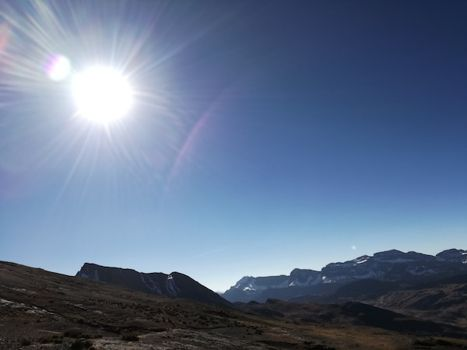

Image 2:


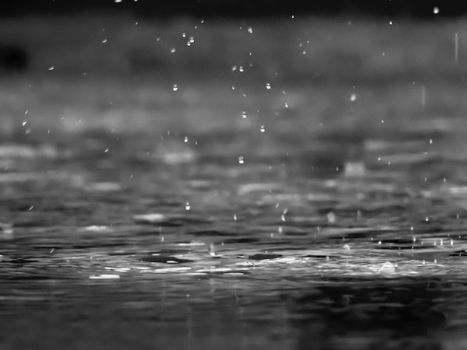

------------------------------ Start of responses ------------------------------


| Question | Answer | Reason |
| -------- | ------ | ------ |
| What does the first image represent? | The sun. | The image shows a bright, shining sun in a clear blue sky. |
| What does the second image represent? | Rain. | The image shows raindrops falling on a surface. |
| What could be a next logical image? | A rainbow. | A rainbow is a natural phenomenon that is often seen after rain. It is caused by the refraction and dispersion of sunlight in water droplets in the atmosphere. |

------------------------------- End of responses -------------------------------



In [25]:
prompt = """
Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What does the first image represent?
- What does the second image represent?
- What could be a next logical image?
"""
caption_w1 = "Image 1:"
caption_w2 = "Image 2:"
# Photo by Diego Ballon Vargas on Unsplash: https://unsplash.com/photos/TA5bUTySOrg
image_w1 = load_image_from_url("https://unsplash.com/photos/TA5bUTySOrg/download?w=600")
# Photo by Reza Shayestehpour on Unsplash: https://unsplash.com/photos/Nw_D8v79PM4
image_w2 = load_image_from_url("https://unsplash.com/photos/Nw_D8v79PM4/download?w=600")

contents = [prompt, caption_w1, image_w1, caption_w2, image_w2]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

This is really up to your imagination:


----------------------------------- Contents -----------------------------------

Answer the following questions, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What theme do these images illustrate?
- What could be another image to replace the first one?
- What other image could replace the second one?
- What would be an alternative to the third image?
- And for the last one?

Image 1:


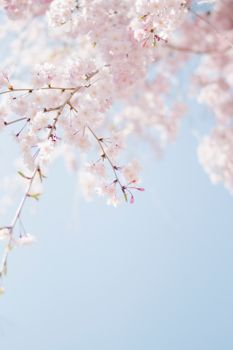

Image 2:


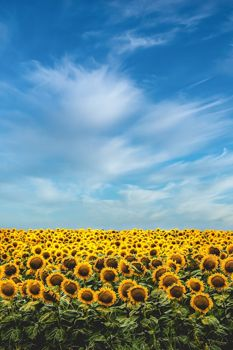

Image 3:


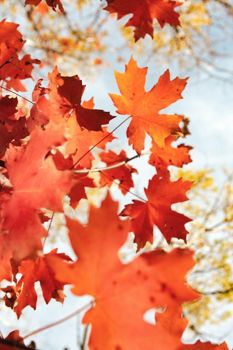

Image 4:


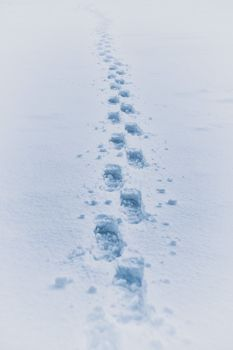

------------------------------ Start of responses ------------------------------


| Question | Answer | Reason |
| -------- | ------ | ------ |
| What theme do these images illustrate? | The four seasons | The images show cherry blossoms in spring, sunflowers in summer, red maple leaves in autumn, and footprints in the snow in winter. |
| What could be another image to replace the first one? | A picture of tulips | Tulips are also a symbol of spring. |
| What other image could replace the second one? | A picture of a field of lavender | Lavender is a flower that blooms in summer and is known for its beautiful purple color. |
| What would be an alternative to the third image? | A picture of a tree with yellow leaves | Yellow leaves are a symbol of autumn. |
| And for the last one? | A picture of a frozen lake | A frozen lake is a symbol of winter. |

------------------------------- End of responses -------------------------------



In [26]:
prompt = """
Answer the following questions, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What theme do these images illustrate?
- What could be another image to replace the first one?
- What other image could replace the second one?
- What would be an alternative to the third image?
- And for the last one?
"""
caption_s1 = "Image 1:"
caption_s2 = "Image 2:"
caption_s3 = "Image 3:"
caption_s4 = "Image 4:"
# Photo by Tomoko Uji on Unsplash: https://unsplash.com/photos/eriuKJwcdjI
image_s1 = load_image_from_url("https://unsplash.com/photos/eriuKJwcdjI/download?w=600")
# Photo by Todd Trapani on Unsplash: https://unsplash.com/photos/QldMpmrmWuc
image_s2 = load_image_from_url("https://unsplash.com/photos/QldMpmrmWuc/download?w=600")
# Photo by Olivia Hutcherson on Unsplash: https://unsplash.com/photos/rN3m7aTH3io
image_s3 = load_image_from_url("https://unsplash.com/photos/rN3m7aTH3io/download?w=600")
# Photo by Eberhard Grossgasteiger on Unsplash: https://unsplash.com/photos/FhdN5QVrBfY
image_s4 = load_image_from_url("https://unsplash.com/photos/FhdN5QVrBfY/download?w=600")

contents = [
    prompt,
    caption_s1,
    image_s1,
    caption_s2,
    image_s2,
    caption_s3,
    image_s3,
    caption_s4,
    image_s4,
]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

### Reasoning on a video


And you also can extract information from a video:


In [27]:
prompt = """
Answer the following questions using the video only.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is the main animal visible throughout the video?
- Which electronic devices are visible?
- What animals are the cartoon characters doing a close-up selfie?
- Which famous brands are visible?
- What is the text visible at the end?
"""
video = Part.from_uri(
    uri="gs://cloud-samples-data/video/animals.mp4",
    mime_type="video/mp4",
)

contents = [prompt, video]
responses = generate_content(multimodal_model, contents)

print_contents(contents)
print_responses(responses)

----------------------------------- Contents -----------------------------------

Answer the following questions using the video only.
Present the results in a table with a row for each question and its answer.

QUESTIONS:
- What is the main animal visible throughout the video?
- Which electronic devices are visible?
- What animals are the cartoon characters doing a close-up selfie?
- Which famous brands are visible?
- What is the text visible at the end?



------------------------------ Start of responses ------------------------------


| Question | Answer |
| -------- | ------ |
| What is the main animal visible throughout the video? | A tiger |
| Which electronic devices are visible? | A smartphone and a camera |
| What animals are the cartoon characters doing a close-up selfie? | A rabbit and a fox |
| Which famous brands are visible? | Google and Disney |
| What is the text visible at the end? | Zootopia Now Playing in 3D |

------------------------------- End of responses -------------------------------



## Conclusion

In this tutorial, you saw examples of how you can use Gemini for education and benefit from text and multimodal models to generate content from text, images, and videos.

You may also want to explore other tutorials that focus on different domains or specificities of the Vertex AI Gemini API.
